In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import glob
import random
import rasterio
import numpy as np
import classic_algos.bicubic_interpolation as bicubic
import classic_algos.lanczos as lanczos
from skimage.color import rgb2ycbcr


import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from pathlib import Path

# Настройки воспроизводимости и ускорения как в статье
import torch.backends.cudnn as cudnn
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device )

cuda


In [2]:
def PSNR(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 10 * torch.log10(1 / (mse + 1e-20))

In [3]:

BATCH_SIZE = 16
EPOCHS = 200

TRAIN_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'train'
VAL_DIR = Path.home() / '.data' / 'UCMerced_LandUse_Split' / 'val'
MODEL_DIR = Path.home() / '.data' / 'fsrcnn_models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)


## Вариант 2: Обучение на Y-канале (Яркость)
Ниже будет реализован второй, независимый пайплайн, который работает только с каналом яркости (Y) из цветового пространства YCbCr.

In [5]:
class SatelliteSRDataset_Y(Dataset):
    def __init__(self, root_dir, scale_factor=2, hr_patch_size=20, augment=True):
        super().__init__()
        self.root_dir = root_dir
        self.scale_factor = scale_factor
        self.hr_patch_size = hr_patch_size
        self.augment = augment
        self.file_paths = glob.glob(os.path.join(root_dir, '**', '*.tif'), recursive=True)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        with rasterio.open(img_path) as src:
            image = src.read()  # C x H x W

        image_norm = image.astype(np.float32) / 255.0

        #random crop
        c, h, w = image_norm.shape
        top = random.randint(0, h - self.hr_patch_size)
        left = random.randint(0, w - self.hr_patch_size)
        hr_patch_np = image_norm[:, top:top+self.hr_patch_size, left:left+self.hr_patch_size]
        if self.augment:
            # Flip Horizontal
            if random.random() < 0.5:
                hr_patch_np = np.flip(hr_patch_np, axis=2)

            # Flip Vertical
            if random.random() < 0.5:
                hr_patch_np = np.flip(hr_patch_np, axis=1)

            # rotations
            k = random.choice([0, 1, 2, 3])
            if k > 0:
                hr_patch_np = np.rot90(hr_patch_np, k, axes=(1, 2))

        hr_patch_np = np.ascontiguousarray(hr_patch_np.astype(np.float32))  # C x H x W, [0,1]
        hr_tensor = torch.from_numpy(hr_patch_np).float()

        # LR from augmented HR patch
        hr_patch_hwc = np.transpose(hr_patch_np, (1, 2, 0))  # H x W x C, [0,1]
        lr_size = self.hr_patch_size // self.scale_factor
        lr_numpy_hwc = bicubic.SR_bicubic(hr_patch_hwc, lr_size, lr_size, preserve_range=True, output_dtype=np.float32)
        lr_numpy = np.transpose(lr_numpy_hwc, (2, 0, 1))  # C x h_lr x w_lr
        lr_tensor = torch.from_numpy(lr_numpy.astype(np.float32))

        return lr_tensor, hr_tensor

import torch
import torch.nn as nn

# === 1. Блок Внимания (Channel Attention) ===
class ChannelAttention(nn.Module):
    def __init__(self, num_features, reduction=16):
        super(ChannelAttention, self).__init__()
        # Global Average Pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # MLP (сжатие -> расширение)
        self.fc = nn.Sequential(
            nn.Conv2d(num_features, num_features // reduction, 1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features // reduction, num_features, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y  # Умножаем вход на "важность" каналов

# === 2. Блок RCAB (вместо ResidualBlock) ===
class RCAB(nn.Module):
    def __init__(self, channels, reduction=16):
        super(RCAB, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            ChannelAttention(channels, reduction)
        )

    def forward(self, x):
        res = self.body(x)
        return res + x  # Skip connection

# === 3. Основная модель (RCAN-lite) ===
class FSRCNN_Y(nn.Module):
    def __init__(self, scale_factor=2, num_channels=3, num_res_blocks=16, n_feats=64):
        """
        num_res_blocks: увеличено до 16 (было 8). Если есть память, можно 20+.
        n_feats: количество фильтров (64 стандарт, можно 96 или 128).
        """
        super(FSRCNN_Y, self).__init__()

        # 1. Head
        self.head = nn.Conv2d(num_channels, n_feats, kernel_size=3, padding=1)

        # 2. Body (много блоков RCAB)
        self.body = nn.Sequential(*[
            RCAB(n_feats) for _ in range(num_res_blocks)
        ])

        self.body_end = nn.Conv2d(n_feats, n_feats, kernel_size=3, padding=1)

        # 3. Upsampling
        if scale_factor == 2:
            self.upsample = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * 4, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
                # Убрали ReLU в конце апсемплинга для более точного восстановления диапазона
            )
        elif scale_factor == 3:
             self.upsample = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * 9, kernel_size=3, padding=1),
                nn.PixelShuffle(3),
            )
        elif scale_factor == 4:
             self.upsample = nn.Sequential(
                nn.Conv2d(n_feats, n_feats * 4, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
                nn.ReLU(inplace=True), # Здесь ReLU можно оставить между блоками
                nn.Conv2d(n_feats, n_feats * 4, kernel_size=3, padding=1),
                nn.PixelShuffle(2),
            )

        # 4. Tail
        self.tail = nn.Conv2d(n_feats, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x_head = self.head(x)

        res = self.body(x_head)
        res = self.body_end(res)
        res += x_head  # Global Residual Learning

        x_up = self.upsample(res)
        out = self.tail(x_up)

        return torch.clamp(out, 0.0, 1.0)

# === 4. Функция потерь Charbonnier ===
class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        loss = torch.mean(torch.sqrt(diff * diff + self.eps * self.eps))
        return loss

In [6]:

y_train_dataset = SatelliteSRDataset_Y(TRAIN_DIR, scale_factor=2, hr_patch_size=144, augment=True)
y_val_dataset = SatelliteSRDataset_Y(VAL_DIR, scale_factor=2, hr_patch_size=144, augment=False)
y_train_loader = DataLoader(y_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
y_val_loader = DataLoader(y_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Модель потяжелее: 16 блоков, 64 канала
y_model = FSRCNN_Y(scale_factor=2, num_res_blocks=16, n_feats=64).to(device)

# Новый Лосс
y_criterion = CharbonnierLoss()

# Оптимизатор тот же (Adam)
y_optimizer = optim.Adam(y_model.parameters(), lr=1e-4, betas=(0.9, 0.999))
y_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(y_optimizer, mode='min', factor=0.5, patience=10)


In [6]:
y_loss = []
y_psnr_metric = []
best_psnr = 0
for epoch in range(EPOCHS):
    y_model.train()
    epoch_loss = 0
    for lr_imgs, hr_imgs in tqdm(y_train_loader, desc=f"Epoch {epoch} (Y)"):
        lr_imgs, hr_imgs = lr_imgs.to(device, non_blocking=True), hr_imgs.to(device, non_blocking=True)
        y_optimizer.zero_grad()
        sr_imgs = y_model(lr_imgs)
        batch_loss = y_criterion(sr_imgs, hr_imgs)
        batch_loss.backward()
        y_optimizer.step()
        epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / len(y_train_loader)
    y_loss.append(avg_loss)
    # === VALIDATION (Каждую эпоху!) ===
    y_model.eval()
    val_loss = 0
    val_psnr = 0
    with torch.no_grad():
        for lr_imgs, hr_imgs in y_val_loader: # убираем tqdm тут, чтобы не засорять лог
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = y_model(lr_imgs)

            # Считаем и Loss, и PSNR
            loss = y_criterion(sr_imgs, hr_imgs)
            val_loss += loss.item()
            val_psnr += PSNR(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(y_val_loader)
    avg_val_psnr = val_psnr / len(y_val_loader)

    print(f"Epoch {epoch}: Train Loss: {avg_loss:.5f} | Val Loss: {avg_val_loss:.5f} | Val PSNR: {avg_val_psnr:.2f} dB")

    # === SCHEDULER STEP ===
    # Скармливаем ему Валидационный Лосс
    y_scheduler.step(avg_val_loss)

    # Сохраняем лучшую модель
    if avg_val_psnr > best_psnr:
        best_psnr = avg_val_psnr
        torch.save(y_model.state_dict(), MODEL_DIR / 'rgb_cooler_best_model.pth')
        print(f"  [!] New Best PSNR: {best_psnr:.2f} dB saved.")

    # Можно сохранять чекпоинт раз в N эпох на всякий случай
    if epoch % 20 == 0:
         torch.save(y_model.state_dict(), MODEL_DIR / f'rgb_cooler_checkpoint_{epoch}.pth')

print("Y-channel training complete.")


Epoch 0 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 0: Train Loss: 0.14230 | Val Loss: 0.10955 | Val PSNR: 12.90 dB
  [!] New Best PSNR: 12.90 dB saved.


Epoch 1 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 1: Train Loss: 0.09387 | Val Loss: 0.06742 | Val PSNR: 15.76 dB
  [!] New Best PSNR: 15.76 dB saved.


Epoch 2 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 2: Train Loss: 0.03702 | Val Loss: 0.02442 | Val PSNR: 26.95 dB
  [!] New Best PSNR: 26.95 dB saved.


Epoch 3 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 3: Train Loss: 0.02360 | Val Loss: 0.02351 | Val PSNR: 27.33 dB
  [!] New Best PSNR: 27.33 dB saved.


Epoch 4 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 4: Train Loss: 0.02261 | Val Loss: 0.02272 | Val PSNR: 27.49 dB
  [!] New Best PSNR: 27.49 dB saved.


Epoch 5 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 5: Train Loss: 0.02213 | Val Loss: 0.02229 | Val PSNR: 27.45 dB


Epoch 6 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 6: Train Loss: 0.02171 | Val Loss: 0.02212 | Val PSNR: 27.63 dB
  [!] New Best PSNR: 27.63 dB saved.


Epoch 7 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 7: Train Loss: 0.02169 | Val Loss: 0.02174 | Val PSNR: 27.71 dB
  [!] New Best PSNR: 27.71 dB saved.


Epoch 8 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 8: Train Loss: 0.02178 | Val Loss: 0.02240 | Val PSNR: 27.57 dB


Epoch 9 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferen

Epoch 9: Train Loss: 0.02110 | Val Loss: 0.02198 | Val PSNR: 27.66 dB


Epoch 10 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 10: Train Loss: 0.02103 | Val Loss: 0.02100 | Val PSNR: 27.77 dB
  [!] New Best PSNR: 27.77 dB saved.


Epoch 11 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 11: Train Loss: 0.02094 | Val Loss: 0.02096 | Val PSNR: 27.76 dB


Epoch 12 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 12: Train Loss: 0.02044 | Val Loss: 0.02135 | Val PSNR: 27.81 dB
  [!] New Best PSNR: 27.81 dB saved.


Epoch 13 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 13: Train Loss: 0.02062 | Val Loss: 0.02112 | Val PSNR: 27.82 dB
  [!] New Best PSNR: 27.82 dB saved.


Epoch 14 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 14: Train Loss: 0.02030 | Val Loss: 0.02058 | Val PSNR: 27.96 dB
  [!] New Best PSNR: 27.96 dB saved.


Epoch 15 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 15: Train Loss: 0.02005 | Val Loss: 0.02082 | Val PSNR: 27.85 dB


Epoch 16 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 16: Train Loss: 0.02008 | Val Loss: 0.02074 | Val PSNR: 27.93 dB


Epoch 17 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 17: Train Loss: 0.01988 | Val Loss: 0.02145 | Val PSNR: 27.89 dB


Epoch 18 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 18: Train Loss: 0.02000 | Val Loss: 0.02072 | Val PSNR: 28.00 dB
  [!] New Best PSNR: 28.00 dB saved.


Epoch 19 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 19: Train Loss: 0.01976 | Val Loss: 0.02047 | Val PSNR: 27.99 dB


Epoch 20 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 20: Train Loss: 0.01964 | Val Loss: 0.02068 | Val PSNR: 28.00 dB
  [!] New Best PSNR: 28.00 dB saved.


Epoch 21 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 21: Train Loss: 0.01961 | Val Loss: 0.02004 | Val PSNR: 28.09 dB
  [!] New Best PSNR: 28.09 dB saved.


Epoch 22 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 22: Train Loss: 0.01941 | Val Loss: 0.01987 | Val PSNR: 28.16 dB
  [!] New Best PSNR: 28.16 dB saved.


Epoch 23 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 23: Train Loss: 0.01961 | Val Loss: 0.01989 | Val PSNR: 28.11 dB


Epoch 24 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 24: Train Loss: 0.01928 | Val Loss: 0.01974 | Val PSNR: 28.19 dB
  [!] New Best PSNR: 28.19 dB saved.


Epoch 25 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 25: Train Loss: 0.01935 | Val Loss: 0.02033 | Val PSNR: 28.18 dB


Epoch 26 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 26: Train Loss: 0.01918 | Val Loss: 0.01970 | Val PSNR: 28.14 dB


Epoch 27 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 27: Train Loss: 0.01929 | Val Loss: 0.02024 | Val PSNR: 28.08 dB


Epoch 28 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 28: Train Loss: 0.01926 | Val Loss: 0.02006 | Val PSNR: 28.17 dB


Epoch 29 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 29: Train Loss: 0.01887 | Val Loss: 0.01957 | Val PSNR: 28.22 dB
  [!] New Best PSNR: 28.22 dB saved.


Epoch 30 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 30: Train Loss: 0.01876 | Val Loss: 0.01913 | Val PSNR: 28.24 dB
  [!] New Best PSNR: 28.24 dB saved.


Epoch 31 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 31: Train Loss: 0.01865 | Val Loss: 0.01953 | Val PSNR: 28.21 dB


Epoch 32 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 32: Train Loss: 0.01892 | Val Loss: 0.01938 | Val PSNR: 28.32 dB
  [!] New Best PSNR: 28.32 dB saved.


Epoch 33 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 33: Train Loss: 0.01883 | Val Loss: 0.01946 | Val PSNR: 28.18 dB


Epoch 34 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 34: Train Loss: 0.01873 | Val Loss: 0.01946 | Val PSNR: 28.26 dB


Epoch 35 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 35: Train Loss: 0.01880 | Val Loss: 0.01965 | Val PSNR: 28.35 dB
  [!] New Best PSNR: 28.35 dB saved.


Epoch 36 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 36: Train Loss: 0.01915 | Val Loss: 0.01963 | Val PSNR: 28.31 dB


Epoch 37 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 37: Train Loss: 0.01884 | Val Loss: 0.01926 | Val PSNR: 28.29 dB


Epoch 38 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 38: Train Loss: 0.01844 | Val Loss: 0.01907 | Val PSNR: 28.39 dB
  [!] New Best PSNR: 28.39 dB saved.


Epoch 39 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 39: Train Loss: 0.01867 | Val Loss: 0.01910 | Val PSNR: 28.40 dB
  [!] New Best PSNR: 28.40 dB saved.


Epoch 40 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 40: Train Loss: 0.01881 | Val Loss: 0.01917 | Val PSNR: 28.34 dB


Epoch 41 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 41: Train Loss: 0.01854 | Val Loss: 0.01905 | Val PSNR: 28.30 dB


Epoch 42 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 42: Train Loss: 0.01852 | Val Loss: 0.01927 | Val PSNR: 28.22 dB


Epoch 43 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 43: Train Loss: 0.01851 | Val Loss: 0.01949 | Val PSNR: 28.25 dB


Epoch 44 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 44: Train Loss: 0.01843 | Val Loss: 0.01917 | Val PSNR: 28.33 dB


Epoch 45 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 45: Train Loss: 0.01863 | Val Loss: 0.01890 | Val PSNR: 28.45 dB
  [!] New Best PSNR: 28.45 dB saved.


Epoch 46 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 46: Train Loss: 0.01828 | Val Loss: 0.01886 | Val PSNR: 28.39 dB


Epoch 47 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 47: Train Loss: 0.01823 | Val Loss: 0.01898 | Val PSNR: 28.37 dB


Epoch 48 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 48: Train Loss: 0.01870 | Val Loss: 0.01922 | Val PSNR: 28.43 dB


Epoch 49 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 49: Train Loss: 0.01834 | Val Loss: 0.01887 | Val PSNR: 28.40 dB


Epoch 50 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 50: Train Loss: 0.01825 | Val Loss: 0.01889 | Val PSNR: 28.41 dB


Epoch 51 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 51: Train Loss: 0.01869 | Val Loss: 0.01890 | Val PSNR: 28.40 dB


Epoch 52 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 52: Train Loss: 0.01822 | Val Loss: 0.01919 | Val PSNR: 28.35 dB


Epoch 53 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 53: Train Loss: 0.01833 | Val Loss: 0.01891 | Val PSNR: 28.38 dB


Epoch 54 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 54: Train Loss: 0.01842 | Val Loss: 0.01934 | Val PSNR: 28.34 dB


Epoch 55 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 55: Train Loss: 0.01831 | Val Loss: 0.01880 | Val PSNR: 28.43 dB


Epoch 56 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 56: Train Loss: 0.01819 | Val Loss: 0.01865 | Val PSNR: 28.46 dB
  [!] New Best PSNR: 28.46 dB saved.


Epoch 57 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 57: Train Loss: 0.01811 | Val Loss: 0.01920 | Val PSNR: 28.46 dB


Epoch 58 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 58: Train Loss: 0.01818 | Val Loss: 0.01912 | Val PSNR: 28.40 dB


Epoch 59 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 59: Train Loss: 0.01814 | Val Loss: 0.01846 | Val PSNR: 28.48 dB
  [!] New Best PSNR: 28.48 dB saved.


Epoch 60 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 60: Train Loss: 0.01824 | Val Loss: 0.01900 | Val PSNR: 28.39 dB


Epoch 61 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 61: Train Loss: 0.01843 | Val Loss: 0.01941 | Val PSNR: 28.41 dB


Epoch 62 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 62: Train Loss: 0.01837 | Val Loss: 0.01875 | Val PSNR: 28.44 dB


Epoch 63 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 63: Train Loss: 0.01809 | Val Loss: 0.01860 | Val PSNR: 28.40 dB


Epoch 64 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 64: Train Loss: 0.01811 | Val Loss: 0.01871 | Val PSNR: 28.46 dB


Epoch 65 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 65: Train Loss: 0.01806 | Val Loss: 0.01890 | Val PSNR: 28.47 dB


Epoch 66 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 66: Train Loss: 0.01811 | Val Loss: 0.01888 | Val PSNR: 28.40 dB


Epoch 67 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 67: Train Loss: 0.01811 | Val Loss: 0.01909 | Val PSNR: 28.40 dB


Epoch 68 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 68: Train Loss: 0.01810 | Val Loss: 0.01864 | Val PSNR: 28.50 dB
  [!] New Best PSNR: 28.50 dB saved.


Epoch 69 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 69: Train Loss: 0.01804 | Val Loss: 0.01891 | Val PSNR: 28.45 dB


Epoch 70 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 70: Train Loss: 0.01813 | Val Loss: 0.01892 | Val PSNR: 28.42 dB


Epoch 71 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 71: Train Loss: 0.01768 | Val Loss: 0.01819 | Val PSNR: 28.59 dB
  [!] New Best PSNR: 28.59 dB saved.


Epoch 72 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 72: Train Loss: 0.01764 | Val Loss: 0.01841 | Val PSNR: 28.47 dB


Epoch 73 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 73: Train Loss: 0.01778 | Val Loss: 0.01835 | Val PSNR: 28.51 dB


Epoch 74 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 74: Train Loss: 0.01767 | Val Loss: 0.01856 | Val PSNR: 28.42 dB


Epoch 75 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 75: Train Loss: 0.01762 | Val Loss: 0.01826 | Val PSNR: 28.49 dB


Epoch 76 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 76: Train Loss: 0.01766 | Val Loss: 0.01839 | Val PSNR: 28.47 dB


Epoch 77 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 77: Train Loss: 0.01754 | Val Loss: 0.01828 | Val PSNR: 28.54 dB


Epoch 78 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 78: Train Loss: 0.01767 | Val Loss: 0.01834 | Val PSNR: 28.52 dB


Epoch 79 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 79: Train Loss: 0.01773 | Val Loss: 0.01856 | Val PSNR: 28.59 dB


Epoch 80 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 80: Train Loss: 0.01765 | Val Loss: 0.01851 | Val PSNR: 28.51 dB


Epoch 81 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 81: Train Loss: 0.01758 | Val Loss: 0.01838 | Val PSNR: 28.48 dB


Epoch 82 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 82: Train Loss: 0.01758 | Val Loss: 0.01834 | Val PSNR: 28.51 dB


Epoch 83 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 83: Train Loss: 0.01752 | Val Loss: 0.01817 | Val PSNR: 28.58 dB


Epoch 84 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 84: Train Loss: 0.01750 | Val Loss: 0.01812 | Val PSNR: 28.54 dB


Epoch 85 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 85: Train Loss: 0.01747 | Val Loss: 0.01831 | Val PSNR: 28.53 dB


Epoch 86 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 86: Train Loss: 0.01748 | Val Loss: 0.01819 | Val PSNR: 28.56 dB


Epoch 87 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 87: Train Loss: 0.01749 | Val Loss: 0.01814 | Val PSNR: 28.63 dB
  [!] New Best PSNR: 28.63 dB saved.


Epoch 88 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 88: Train Loss: 0.01752 | Val Loss: 0.01811 | Val PSNR: 28.66 dB
  [!] New Best PSNR: 28.66 dB saved.


Epoch 89 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 89: Train Loss: 0.01754 | Val Loss: 0.01817 | Val PSNR: 28.61 dB


Epoch 90 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 90: Train Loss: 0.01752 | Val Loss: 0.01819 | Val PSNR: 28.56 dB


Epoch 91 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 91: Train Loss: 0.01754 | Val Loss: 0.01842 | Val PSNR: 28.47 dB


Epoch 92 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 92: Train Loss: 0.01752 | Val Loss: 0.01820 | Val PSNR: 28.53 dB


Epoch 93 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 93: Train Loss: 0.01753 | Val Loss: 0.01825 | Val PSNR: 28.51 dB


Epoch 94 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 94: Train Loss: 0.01747 | Val Loss: 0.01844 | Val PSNR: 28.45 dB


Epoch 95 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 95: Train Loss: 0.01748 | Val Loss: 0.01842 | Val PSNR: 28.45 dB


Epoch 96 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 96: Train Loss: 0.01746 | Val Loss: 0.01818 | Val PSNR: 28.52 dB


Epoch 97 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 97: Train Loss: 0.01748 | Val Loss: 0.01805 | Val PSNR: 28.64 dB


Epoch 98 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 98: Train Loss: 0.01750 | Val Loss: 0.01803 | Val PSNR: 28.65 dB


Epoch 99 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefere

Epoch 99: Train Loss: 0.01749 | Val Loss: 0.01813 | Val PSNR: 28.66 dB


Epoch 100 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 100: Train Loss: 0.01751 | Val Loss: 0.01811 | Val PSNR: 28.62 dB


Epoch 101 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 101: Train Loss: 0.01745 | Val Loss: 0.01822 | Val PSNR: 28.56 dB


Epoch 102 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 102: Train Loss: 0.01736 | Val Loss: 0.01807 | Val PSNR: 28.59 dB


Epoch 103 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 103: Train Loss: 0.01744 | Val Loss: 0.01813 | Val PSNR: 28.58 dB


Epoch 104 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 104: Train Loss: 0.01749 | Val Loss: 0.01830 | Val PSNR: 28.52 dB


Epoch 105 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 105: Train Loss: 0.01746 | Val Loss: 0.01821 | Val PSNR: 28.54 dB


Epoch 106 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 106: Train Loss: 0.01744 | Val Loss: 0.01838 | Val PSNR: 28.56 dB


Epoch 107 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 107: Train Loss: 0.01743 | Val Loss: 0.01817 | Val PSNR: 28.56 dB


Epoch 108 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 108: Train Loss: 0.01741 | Val Loss: 0.01820 | Val PSNR: 28.57 dB


Epoch 109 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 109: Train Loss: 0.01744 | Val Loss: 0.01823 | Val PSNR: 28.54 dB


Epoch 110 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 110: Train Loss: 0.01742 | Val Loss: 0.01809 | Val PSNR: 28.59 dB


Epoch 111 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 111: Train Loss: 0.01735 | Val Loss: 0.01826 | Val PSNR: 28.53 dB


Epoch 112 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 112: Train Loss: 0.01742 | Val Loss: 0.01807 | Val PSNR: 28.66 dB
  [!] New Best PSNR: 28.66 dB saved.


Epoch 113 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 113: Train Loss: 0.01731 | Val Loss: 0.01830 | Val PSNR: 28.48 dB


Epoch 114 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 114: Train Loss: 0.01739 | Val Loss: 0.01803 | Val PSNR: 28.61 dB


Epoch 115 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 115: Train Loss: 0.01737 | Val Loss: 0.01795 | Val PSNR: 28.65 dB


Epoch 116 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 116: Train Loss: 0.01733 | Val Loss: 0.01804 | Val PSNR: 28.65 dB


Epoch 117 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 117: Train Loss: 0.01735 | Val Loss: 0.01818 | Val PSNR: 28.54 dB


Epoch 118 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 118: Train Loss: 0.01741 | Val Loss: 0.01823 | Val PSNR: 28.55 dB


Epoch 119 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 119: Train Loss: 0.01741 | Val Loss: 0.01819 | Val PSNR: 28.52 dB


Epoch 120 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 120: Train Loss: 0.01734 | Val Loss: 0.01815 | Val PSNR: 28.55 dB


Epoch 121 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 121: Train Loss: 0.01741 | Val Loss: 0.01806 | Val PSNR: 28.63 dB


Epoch 122 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 122: Train Loss: 0.01734 | Val Loss: 0.01790 | Val PSNR: 28.72 dB
  [!] New Best PSNR: 28.72 dB saved.


Epoch 123 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 123: Train Loss: 0.01730 | Val Loss: 0.01831 | Val PSNR: 28.51 dB


Epoch 124 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 124: Train Loss: 0.01736 | Val Loss: 0.01795 | Val PSNR: 28.66 dB


Epoch 125 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 125: Train Loss: 0.01737 | Val Loss: 0.01827 | Val PSNR: 28.54 dB


Epoch 126 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 126: Train Loss: 0.01733 | Val Loss: 0.01811 | Val PSNR: 28.60 dB


Epoch 127 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 127: Train Loss: 0.01736 | Val Loss: 0.01783 | Val PSNR: 28.75 dB
  [!] New Best PSNR: 28.75 dB saved.


Epoch 128 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 128: Train Loss: 0.01732 | Val Loss: 0.01812 | Val PSNR: 28.56 dB


Epoch 129 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 129: Train Loss: 0.01730 | Val Loss: 0.01797 | Val PSNR: 28.64 dB


Epoch 130 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 130: Train Loss: 0.01730 | Val Loss: 0.01814 | Val PSNR: 28.60 dB


Epoch 131 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 131: Train Loss: 0.01729 | Val Loss: 0.01807 | Val PSNR: 28.61 dB


Epoch 132 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 132: Train Loss: 0.01736 | Val Loss: 0.01788 | Val PSNR: 28.71 dB


Epoch 133 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 133: Train Loss: 0.01730 | Val Loss: 0.01797 | Val PSNR: 28.65 dB


Epoch 134 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 134: Train Loss: 0.01731 | Val Loss: 0.01806 | Val PSNR: 28.63 dB


Epoch 135 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 135: Train Loss: 0.01725 | Val Loss: 0.01808 | Val PSNR: 28.56 dB


Epoch 136 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 136: Train Loss: 0.01729 | Val Loss: 0.01824 | Val PSNR: 28.51 dB


Epoch 137 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 137: Train Loss: 0.01727 | Val Loss: 0.01806 | Val PSNR: 28.65 dB


Epoch 138 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 138: Train Loss: 0.01725 | Val Loss: 0.01802 | Val PSNR: 28.65 dB


Epoch 139 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 139: Train Loss: 0.01735 | Val Loss: 0.01793 | Val PSNR: 28.66 dB


Epoch 140 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 140: Train Loss: 0.01728 | Val Loss: 0.01790 | Val PSNR: 28.69 dB


Epoch 141 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 141: Train Loss: 0.01727 | Val Loss: 0.01809 | Val PSNR: 28.55 dB


Epoch 142 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 142: Train Loss: 0.01724 | Val Loss: 0.01814 | Val PSNR: 28.56 dB


Epoch 143 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 143: Train Loss: 0.01729 | Val Loss: 0.01812 | Val PSNR: 28.61 dB


Epoch 144 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 144: Train Loss: 0.01725 | Val Loss: 0.01798 | Val PSNR: 28.64 dB


Epoch 145 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 145: Train Loss: 0.01730 | Val Loss: 0.01808 | Val PSNR: 28.65 dB


Epoch 146 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 146: Train Loss: 0.01730 | Val Loss: 0.01806 | Val PSNR: 28.64 dB


Epoch 147 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 147: Train Loss: 0.01725 | Val Loss: 0.01804 | Val PSNR: 28.60 dB


Epoch 148 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 148: Train Loss: 0.01731 | Val Loss: 0.01813 | Val PSNR: 28.61 dB


Epoch 149 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 149: Train Loss: 0.01723 | Val Loss: 0.01816 | Val PSNR: 28.57 dB


Epoch 150 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 150: Train Loss: 0.01727 | Val Loss: 0.01789 | Val PSNR: 28.68 dB


Epoch 151 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 151: Train Loss: 0.01735 | Val Loss: 0.01795 | Val PSNR: 28.62 dB


Epoch 152 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 152: Train Loss: 0.01726 | Val Loss: 0.01798 | Val PSNR: 28.64 dB


Epoch 153 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 153: Train Loss: 0.01723 | Val Loss: 0.01798 | Val PSNR: 28.66 dB


Epoch 154 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 154: Train Loss: 0.01722 | Val Loss: 0.01804 | Val PSNR: 28.60 dB


Epoch 155 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

Epoch 155: Train Loss: 0.01725 | Val Loss: 0.01796 | Val PSNR: 28.63 dB


Epoch 156 (Y):   0%|          | 0/105 [00:00<?, ?it/s]/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/aaa/miniconda3/envs/super-resolution/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeorefer

KeyboardInterrupt: 

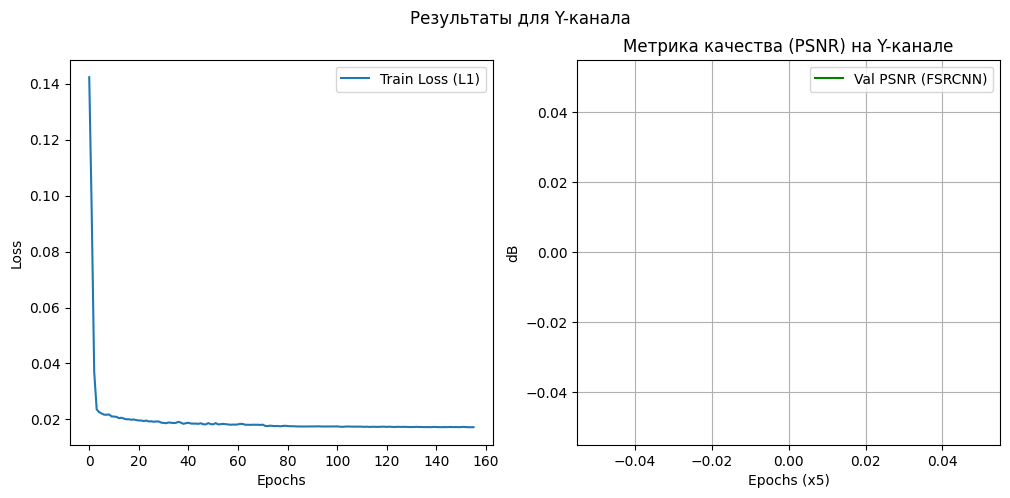

In [7]:
# 5. Визуализация результатов для Y-версии
plt.figure(figsize=(12, 5))
plt.suptitle("Результаты для Y-канала")

plt.subplot(1, 2, 1)
plt.plot(y_loss, label='Train Loss (L1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_psnr_metric, label='Val PSNR (FSRCNN)', color='green')
plt.title('Метрика качества (PSNR) на Y-канале')
plt.xlabel('Epochs (x5)')
plt.ylabel('dB')
plt.legend()
plt.grid(True)

plt.show()

File: /home/aaa/.data/UCMerced_LandUse_Split/val/parkinglot/parkinglot24.tif
Loading weights: /home/aaa/.data/fsrcnn_models/rgb_cooler_best_model.pth


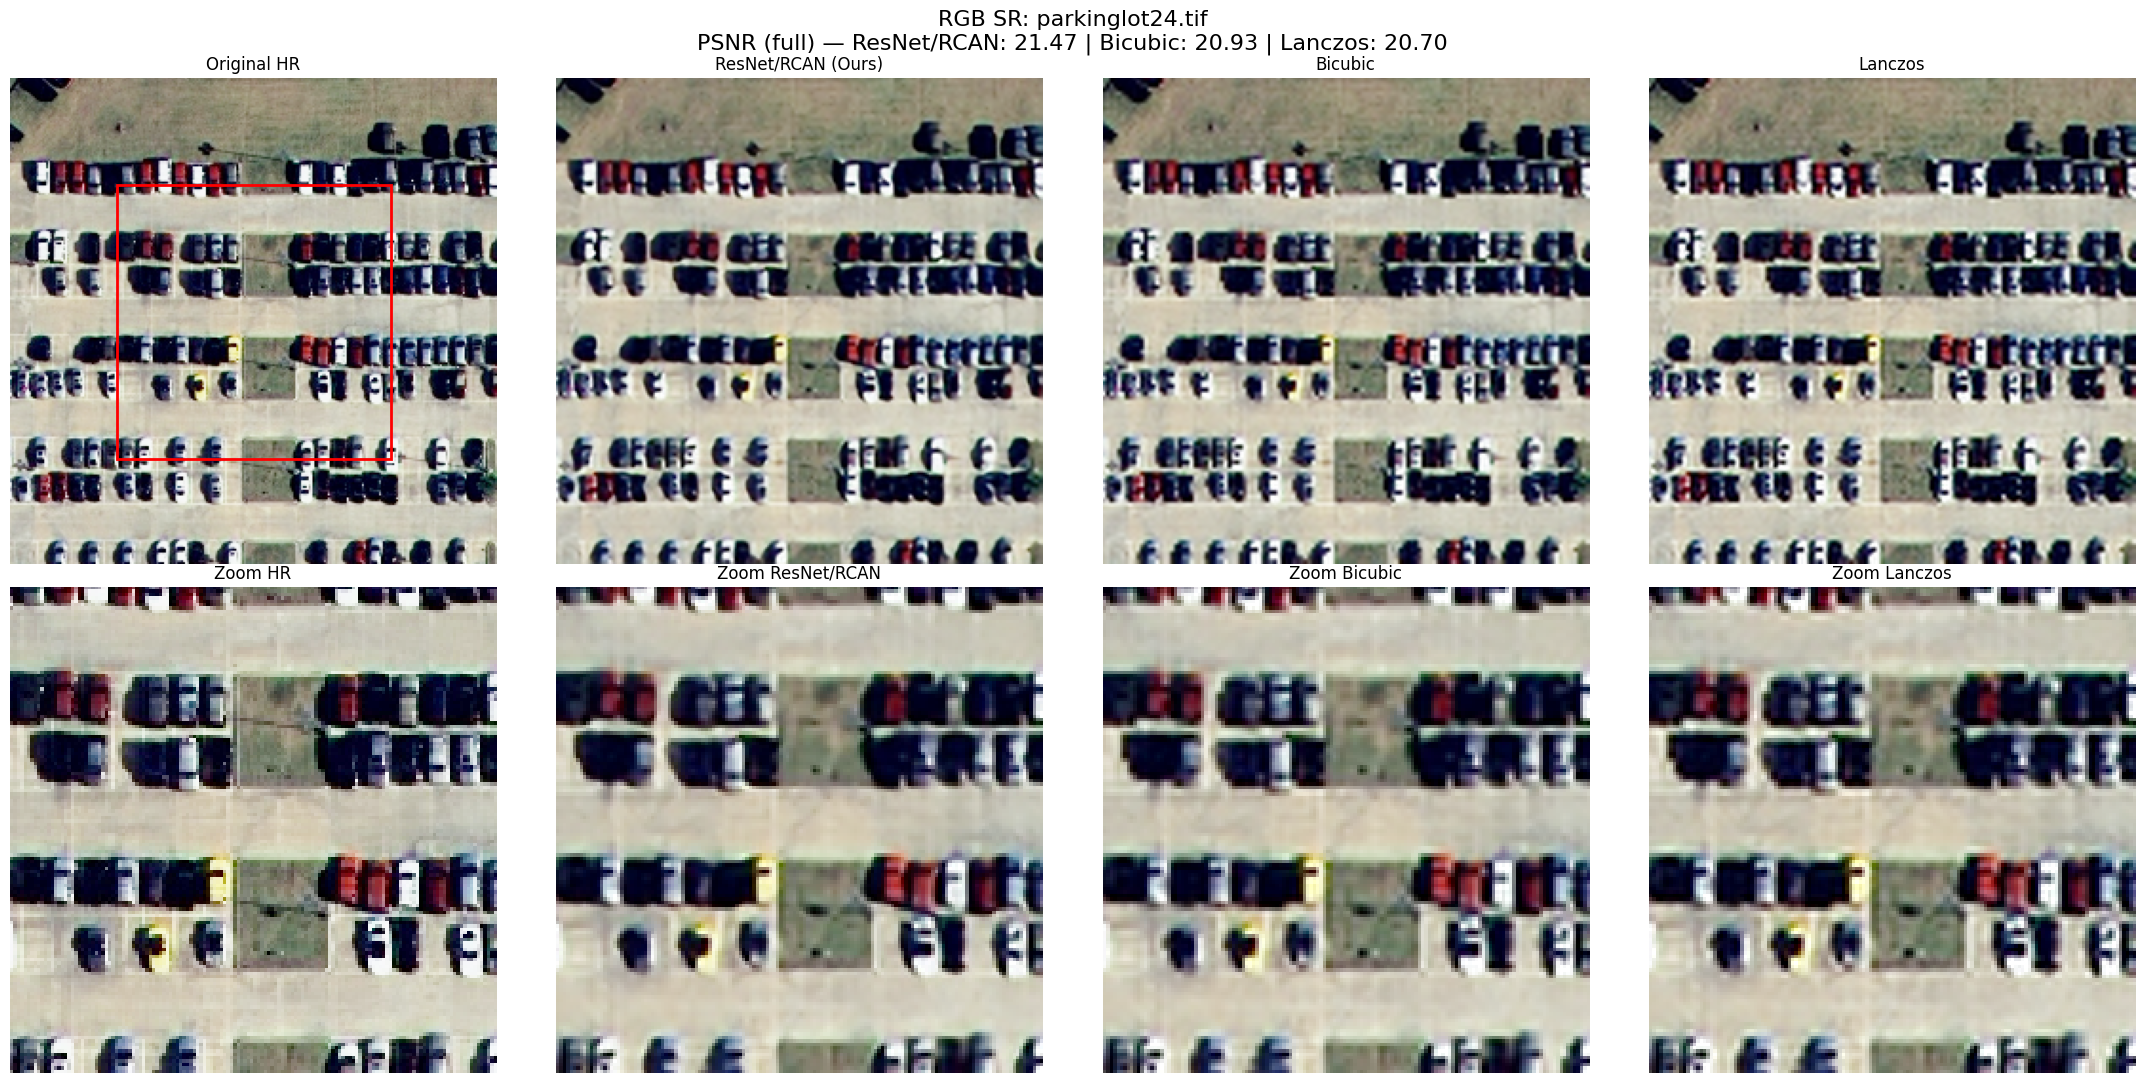

Zoom Area: Top=56, Left=56, Size=144


In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import rasterio
import random
from pathlib import Path

# === НАСТРОЙКИ ===
ZOOM_PATCH_SIZE = 144   # размер квадрата для зума
ZOOM_TOP_LEFT = None   # (top, left) или None
SCALE_Y = 2            # Ваш масштаб

# Убедитесь, что параметры совпадают с теми, на которых обучали!
# Если обучали SatelliteRCAN, замените класс FSRCNN_Y на SatelliteRCAN
MODEL_ARCH = FSRCNN_Y
N_CHANNELS = 3         # <--- ТЕПЕРЬ 3 КАНАЛА
N_RES_BLOCKS = 16      # Укажите то число, с которым обучали (8 или 16)
N_FEATS = 64           # Укажите число фильтров (64 или 56)

# 1) Загрузка изображения (RGB)
full_idx = random.randint(0, len(y_val_dataset.file_paths) - 1)
img_path = y_val_dataset.file_paths[full_idx]
print(f"File: {img_path}")

with rasterio.open(img_path) as src:
    image = src.read()  # (C, H, W)
    profile_dtype = src.profile['dtype']

# Нормализация [0, 1] с учетом битности
if profile_dtype == 'uint16':
    image = image.astype(np.float32) / 65535.0
else:
    image = image.astype(np.float32) / 255.0

# Гарантируем 3 канала (RGB)
if image.shape[0] > 3:
    image = image[:3, :, :]
elif image.shape[0] == 1:
    image = np.repeat(image, 3, axis=0)

image_rgb = np.clip(image, 0.0, 1.0) # (3, H, W)

# Приведение размеров к кратности SCALE
C, H, W = image_rgb.shape
H_adj = H - (H % SCALE_Y)
W_adj = W - (W % SCALE_Y)
image_rgb = image_rgb[:, :H_adj, :W_adj] # (3, H, W)

# 2) Подготовка LR (Low Resolution)
lr_h = H_adj // SCALE_Y
lr_w = W_adj // SCALE_Y

# Для бикубика нужен формат (H, W, C)
image_rgb_hwc = np.transpose(image_rgb, (1, 2, 0)) # (H, W, 3)

# Даунскейл (бикубик)
lr_rgb_hwc = bicubic.SR_bicubic(image_rgb_hwc, lr_w, lr_h,
                                preserve_range=True, output_dtype=np.float32)

# Обратно в тензор (1, 3, H, W) для модели
lr_rgb_chw = np.transpose(lr_rgb_hwc, (2, 0, 1))
lr_tensor = torch.from_numpy(lr_rgb_chw).unsqueeze(0).float().to(device)

# 3) Инференс Модели
# Важно: передаем num_channels=3 и параметры архитектуры как при обучении
model_vis = MODEL_ARCH(scale_factor=SCALE_Y, num_channels=N_CHANNELS,
                       num_res_blocks=N_RES_BLOCKS, n_feats=N_FEATS).to(device)

latest_ckpt = '/home/aaa/.data/fsrcnn_models/rgb_cooler_best_model.pth' # Ваш путь

try:
    checkpoint = torch.load(latest_ckpt, map_location=device)
    # Если сохраняли весь словарь, достаем веса
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model_vis.load_state_dict(checkpoint['model_state_dict'])
    else:
        model_vis.load_state_dict(checkpoint)
    model_vis.eval()
except Exception as e:
    print(f"ERROR loading model: {e}")
    # Не продолжаем с рандомными весами, чтобы не смотреть шум
    # raise e

with torch.no_grad():
    sr_model_tensor = model_vis(lr_tensor) # (1, 3, H, W)

# 4) Базовые методы (Bicubic / Lanczos) для сравнения
# Апскейл обратно до HR размера
sr_bicubic_hwc = bicubic.SR_bicubic(lr_rgb_hwc, W_adj, H_adj,
                                    preserve_range=True, output_dtype=np.float32)
sr_lanczos_hwc = lanczos.resize_lanczos_vectorized(lr_rgb_hwc, H_adj, W_adj,
                                                   preserve_range=True, output_dtype=np.float32)

# Перевод в тензоры для расчета PSNR
sr_bicubic_tensor = torch.from_numpy(np.transpose(sr_bicubic_hwc, (2, 0, 1))).unsqueeze(0).to(device)
sr_lanczos_tensor = torch.from_numpy(np.transpose(sr_lanczos_hwc, (2, 0, 1))).unsqueeze(0).to(device)
hr_tensor = torch.from_numpy(image_rgb).unsqueeze(0).to(device)

# 5) Метрики
psnr_model = PSNR(sr_model_tensor, hr_tensor).item()
psnr_bicubic = PSNR(sr_bicubic_tensor, hr_tensor).item()
psnr_lanczos = PSNR(sr_lanczos_tensor, hr_tensor).item()

# 6) Визуализация
# Функция для вырезания зума
if ZOOM_TOP_LEFT is None:
    top = max((H_adj - ZOOM_PATCH_SIZE) // 2, 0)
    left = max((W_adj - ZOOM_PATCH_SIZE) // 2, 0)
else:
    top, left = ZOOM_TOP_LEFT
    top = min(max(0, int(top)), H_adj - ZOOM_PATCH_SIZE)
    left = min(max(0, int(left)), W_adj - ZOOM_PATCH_SIZE)

def get_crops(tensor_img):
    # tensor: (1, 3, H, W)
    full = tensor_img.squeeze().detach().cpu().numpy() # (3, H, W)
    full = np.transpose(full, (1, 2, 0)) # (H, W, 3) для matplotlib

    crop = full[top:top+ZOOM_PATCH_SIZE, left:left+ZOOM_PATCH_SIZE, :]
    return full, crop

hr_full, hr_crop = get_crops(hr_tensor)
sr_full, sr_crop = get_crops(sr_model_tensor)
bi_full, bi_crop = get_crops(sr_bicubic_tensor)
la_full, la_crop = get_crops(sr_lanczos_tensor)

# Рисуем
fig, axes = plt.subplots(2, 4, figsize=(22, 11))
model_name = "ResNet/RCAN" # Или как вы назвали модель

fig.suptitle(f'RGB SR: {Path(img_path).name}\nPSNR (full) — {model_name}: {psnr_model:.2f} | Bicubic: {psnr_bicubic:.2f} | Lanczos: {psnr_lanczos:.2f}', fontsize=16)

# Верхний ряд - Полные кадры
imgs_full = [hr_full, sr_full, bi_full, la_full]
titles = ['Original HR', f'{model_name} (Ours)', 'Bicubic', 'Lanczos']

for ax, img, title in zip(axes[0], imgs_full, titles):
    # cmap='gray' УБРАН, так как теперь RGB
    ax.imshow(np.clip(img, 0, 1))
    ax.axis('off')
    ax.set_title(title, fontsize=12)

# Нижний ряд - Зумы
imgs_crop = [hr_crop, sr_crop, bi_crop, la_crop]
titles_zoom = ['Zoom HR', f'Zoom {model_name}', 'Zoom Bicubic', 'Zoom Lanczos']

for ax, img, title in zip(axes[1], imgs_crop, titles_zoom):
    ax.imshow(np.clip(img, 0, 1))
    ax.axis('off')
    ax.set_title(title, fontsize=12)

# Рисуем рамку на оригинале, чтобы видеть где зум
rect = plt.Rectangle((left, top), ZOOM_PATCH_SIZE, ZOOM_PATCH_SIZE, linewidth=2, edgecolor='r', facecolor='none')
axes[0, 0].add_patch(rect)

plt.tight_layout()
plt.show()


print(f"Zoom Area: Top={top}, Left={left}, Size={ZOOM_PATCH_SIZE}")